<a href="https://colab.research.google.com/github/JinkyoHan/PINN_Elastic_Plate/blob/main/FvK_PDE_038.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINNs + FvK Equation

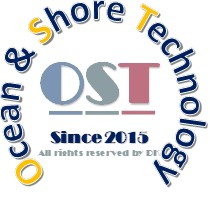



# **V. 0.3.8**

Implemented by Jinkyo Han
38jinkyo@snu.ac.kr

---

# References

- Li, W., Bazant, M. Z., & Zhu, J. (2021). A physics-guided neural network framework for elastic plates: Comparison of governing equations-based and energy-based approaches. Computer Methods in Applied Mechanics and Engineering, 383, 113933.

 https://github.com/weili101/Deep_Plates

- Yu, B. (2018). The deep Ritz method: a deep learning-based numerical algorithm for solving variational problems. Communications in Mathematics and Statistics, 6(1), 1-12.

- Sirignano, J., & Spiliopoulos, K. (2018). DGM: A deep learning algorithm for solving partial differential equations. Journal of computational physics, 375, 1339-1364.

- Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational physics, 378, 686-707.

- Karniadakis, G. E., Kevrekidis, I. G., Lu, L., Perdikaris, P., Wang, S., & Yang, L. (2021). Physics-informed machine learning. Nature Reviews Physics, 3(6), 422-440.

- Panda, S. K., & Ramachandra, L. S. (2010). Buckling of rectangular plates with various boundary conditions loaded by non-uniform inplane loads. International Journal of Mechanical Sciences, 52(6), 819-828.

- Dym, Clive L., and Irving Herman Shames. Solid mechanics. New York, NY, USA:: McGraw-Hill, 1973.

- Landau, L. D., Lifshitz, E. M., Kosevich, A. M., & Pitaevskii, L. P. (1986). Theory of elasticity: volume 7 (Vol. 7). Elsevier.

In [44]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch.optim.lr_scheduler import StepLR

In [45]:
# Problem Statements

E = 70000 # N/mm^2 or GPa
mu = 0.3

h = 1 # mm
q = 0 # N
a = 50 # mm
b = 50 # mm

D = E*h**3/(1-mu**2)/12.
C = E*h/(1 - mu**2)

u_disp = 0.5 # mm, how much to compress
eps_ = u_disp / 2 / a

# Shape Functions
func_u1 = lambda x: (x[:,0]-1)*(x[:,0]+1)*(x[:,0])
func_u2 = lambda x: (x[:,0])

func_v1 = lambda x: (x[:,1])

func_w = lambda x: (x[:,0]+1)*(x[:,0]-1)*(x[:,1]+1)*(x[:,1]-1)

In [46]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer

        self.Input = nn.Linear(n_input, n_nodes)
        nn.init.xavier_uniform_(self.Input.weight)
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)

        self.Hidden = nn.ModuleList()
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)


    def forward(self, x):
        y = torch.tanh(self.Input(x))
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

In [47]:
def derivatives_1(x, w):

    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    return dw_x, dw_y

In [48]:
def derivatives_2(x, w):

    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    # second partial derivative
    dw_xxy = torch.autograd.grad(dw_x, x, torch.ones_like(dw_x), retain_graph=True,
    create_graph=True,allow_unused=True)
    dw_xx = dw_xxy[0][:,0].view(-1,1)
    dw_xy = dw_xxy[0][:,1].view(-1,1)
    dw_yy = torch.autograd.grad(dw_y, x, torch.ones_like(dw_y), retain_graph=True,
    create_graph=True,allow_unused=True)[0][:,1].view(-1,1)

    return dw_x, dw_y, dw_xx, dw_yy, dw_xy

# Resultants

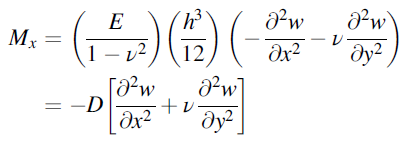

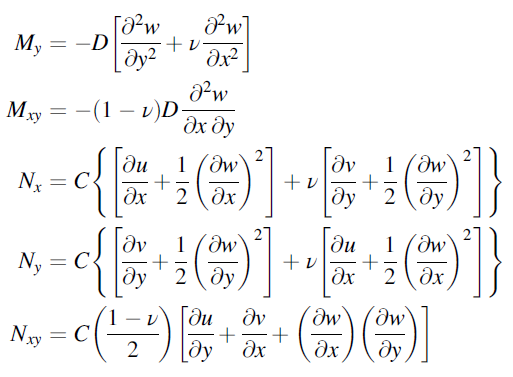

# Governing Equation & BC

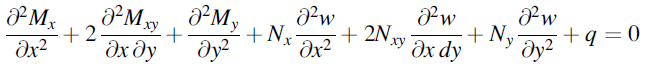

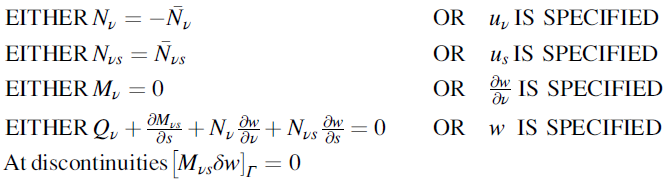

In [49]:
def FvK_equation(x, Net_w, Net_u, Net_v):

    w = Net_w(x) * (func_w(x).view(-1, 1))
    u = Net_u(x) * (func_u1(x).view(-1, 1)) - eps_ * (func_u2(x).view(-1, 1))
    v = Net_v(x) * (func_v1(x).view(-1, 1))

    # Calculate Derivatives
    dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(x, w)
    du_x, du_y = derivatives_1(x, u)
    dv_x, dv_y = derivatives_1(x, v)

    # Dimensionalize parameters
    w, u, v = w*h, u*a, v*b
    dw_x, dw_y = dw_x*h/a, dw_y*h/b
    du_x, du_y = du_x*a/a, du_y*a/b
    dv_x, dv_y = dw_x*b/a, dw_y*b/b
    dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b

      # Resultants
    N_xx = C*((du_x+0.5*dw_x**2) + mu*(dv_y+0.5*dw_y**2))
    N_yy = C*((dv_y+0.5*dw_y**2) + mu*(du_x+0.5*dw_x**2))
    N_xy = C*(1 - mu)*0.5*(du_y+dv_x+dw_x*dw_y)

    M_xx = -D*(dw_xx+mu*dw_yy)
    M_yy = -D*(dw_yy+mu*dw_xx)
    M_xy = -D*(1 - mu)*dw_xy

    # 2nd derivative of dM_xx
    dM_xx_x = torch.autograd.grad(M_xx, x, torch.ones_like(M_xx),
    retain_graph=True, create_graph=True, allow_unused=True)[0][:,0].view(-1,1)
    dM_xx_xx = torch.autograd.grad(dM_xx_x, x, torch.ones_like(dM_xx_x),
    retain_graph=True, create_graph=True,allow_unused=True)[0][:,0].view(-1,1)

    # 2nd derivative of dM_yy
    dM_yy_y = torch.autograd.grad(M_yy, x, torch.ones_like(M_yy),
    retain_graph=True, create_graph=True, allow_unused=True)[0][:,1].view(-1,1)
    dM_yy_yy = torch.autograd.grad(dM_yy_y, x, torch.ones_like(dM_yy_y),
    retain_graph=True, create_graph=True,allow_unused=True)[0][:,1].view(-1,1)

    # 2nd derivative of dM_xy
    dM_xy_x = torch.autograd.grad(M_xy, x, torch.ones_like(M_xy),
    retain_graph=True, create_graph=True, allow_unused=True)[0][:,0].view(-1,1)
    dM_xy_xy = torch.autograd.grad(dM_xy_x, x, torch.ones_like(dM_xy_x),
    retain_graph=True, create_graph=True,allow_unused=True)[0][:,1].view(-1,1)

    # PDE: Classic FvK Equation
    # unit: N/mm^2
    PDE = (dM_xx_xx + 2*dM_xy_xy + dM_yy_yy + N_xx*dw_xx + 2*N_xy*dw_xy + N_yy*dw_yy + q)**2

    # BC: to be implemented by yourself.
    BC_v  = (N_yy[x[:,1]== -1]/a)**2
    BC_v += (N_yy[x[:,1]==  1]/a)**2

    BC_s  = (N_xy[x[:,0]== -1]/b)**2
    BC_s += (N_xy[x[:,0]==  1]/b)**2
    BC_s += (N_xy[x[:,1]== -1]/a)**2
    BC_s += (N_xy[x[:,1]==  1]/a)**2

    BC_m  = (M_xx[x[:,1]== -1]/a**2)**2
    BC_m += (M_xx[x[:,1]==  1]/a**2)**2
    BC_m += (M_yy[x[:,0]== -1]/b**2)**2
    BC_m += (M_yy[x[:,0]==  1]/b**2)**2

    BC = BC_v + BC_s + BC_m

    return torch.mean(PDE), torch.mean(BC)

# Total Potential Energy
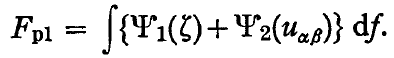

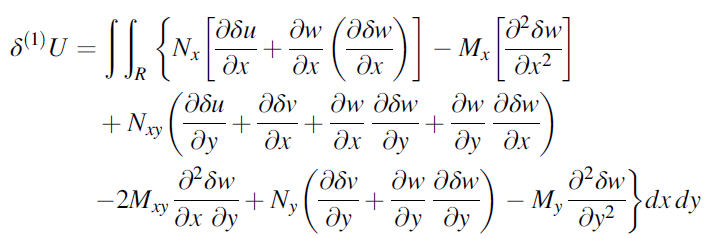


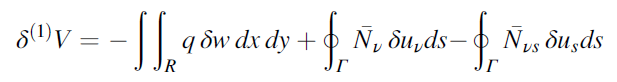

In [50]:
def Energy_density(x, Net_w, Net_u, Net_v):

    w = Net_w(x) * (func_w(x).view(-1, 1))
    u = Net_u(x) * (func_u1(x).view(-1, 1)) - eps_ * (func_u2(x).view(-1, 1))
    v = Net_v(x) * (func_v1(x).view(-1, 1))

    # Calculate Derivatives
    dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(x, w)
    du_x, du_y = derivatives_1(x, u)
    dv_x, dv_y = derivatives_1(x, v)

    # Dimensionalize parameters
    w, u, v = w*h, u*a, v*b
    dw_x, dw_y = dw_x*h/a, dw_y*h/b
    du_x, du_y = du_x*a/a, du_y*a/b
    dv_x, dv_y = dw_x*b/a, dw_y*b/b
    dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b

    eps_xx = du_x + 0.5*dw_x**2
    eps_yy = dv_y + 0.5*dw_y**2
    eps_xy = 0.5*(du_y + dv_x + dw_y*dw_x)

    N_xx = C*(eps_xx + mu*eps_yy)
    N_yy = C*(eps_yy + mu*eps_xx)
    N_xy = C*(1 - mu)*eps_xy

    k_xx = -dw_xx
    k_yy = -dw_yy
    k_xy = -dw_xy

    M_xx = D*(k_xx + mu*k_yy)
    M_yy = D*(k_yy + mu*k_xx)
    M_xy = D*(1 - mu)*dw_xy

    # Energy: unit = N/mm
    U_m = 0.5*(eps_xx*N_xx + eps_yy*N_yy + 2*eps_xy*N_xy)
    U_b = 0.5*(k_xx*M_xx + k_yy*M_yy + 2*k_xy*M_xy)
    U_e = (u[x[:,0]==1]*N_xx[x[:,0]==1] - u[x[:,0]==-1]*N_xx[x[:,0]==-1])/b

    # BC: to be implemented by yourself.
    BC_v  = (N_yy[x[:,1]== -1])**2
    BC_v += (N_yy[x[:,1]==  1])**2

    BC_s  = (N_xy[x[:,0]== -1])**2
    BC_s += (N_xy[x[:,0]==  1])**2
    BC_s += (N_xy[x[:,1]== -1])**2
    BC_s += (N_xy[x[:,1]==  1])**2

    BC_m  = (M_xx[x[:,1]== -1]/a)**2
    BC_m += (M_xx[x[:,1]==  1]/a)**2
    BC_m += (M_yy[x[:,0]== -1]/b)**2
    BC_m += (M_yy[x[:,0]==  1]/b)**2

    BC = BC_v + BC_s + BC_m

    return torch.mean(U_m), torch.mean(U_b), torch.mean(U_e), torch.mean(BC)

In [62]:
def train_data(Nx, Ny, Nf):
    x = np.linspace(-1, 1, Nx).reshape([Nx, 1])
    y = np.linspace(-1, 1, Ny).reshape([Ny, 1])

    # Points at Boundary
    Xb = np.vstack([np.hstack([x, np.full_like(x, -1)]),  # lower
                    np.hstack([x, np.full_like(x, 1)]),   # upper
                    np.hstack([np.full_like(y, -1), y]),  # left
                    np.hstack([np.full_like(y, 1), y])])  # right
    Xb = np.unique(Xb, axis=0)
    Xf1 = torch.tensor(Xb, dtype=torch.float32, requires_grad=True)

    # Points inside domain
    while True:
        Xf2 = np.random.rand(Nf, 2) * 2 - 1
        # eliminate points at boundary
        Xf2 = Xf2[~((np.isclose(Xf2[:, 0], -1) | np.isclose(Xf2[:, 0], 1)) |
                    (np.isclose(Xf2[:, 1], -1) | np.isclose(Xf2[:, 1], 1)))]
        if len(Xf2) >= Nf:
            break
    Xf2 = Xf2[:Nf]
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)

    return Xf1, Xf2


In [77]:
# Prepare training data
Nx1 = 30
Ny1 = 30
Nf1 = 8000

Xf1, Xf2 = train_data(Nx1, Ny1, Nf1)
Xf = torch.cat([Xf1, Xf2], dim=0)

Net_w = Net(2, 1, 5, 5)
Net_u = Net(2, 1, 5, 5)
Net_v = Net(2, 1, 5, 5)

In [78]:
# Pretraining the neural network to fit different initial buckling mode
nepoches = 2000
learning_rate = 2e-3
# optimizer_w = torch.optim.Adam(Net_w.parameters(), lr=learning_rate)
# optimizer_f = torch.optim.Adam(Net_f.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(Net_w.parameters()) + list(Net_u.parameters()) + list(Net_v.parameters()),
                             lr= learning_rate)
for epoch in range(nepoches):

    w = Net_w(Xf2) * (func_w(Xf2).view(-1, 1))
    u = Net_u(Xf2) * (func_u1(Xf2).view(-1, 1)) - eps_ * (func_u2(Xf2).view(-1, 1))
    v = Net_v(Xf2) * (func_v1(Xf2).view(-1, 1))

    loss1 = torch.mean((w - torch.cos(Xf2[:,0].view(-1,1)*3.14*0.5)*torch.cos(Xf2[:,1].view(-1,1)*3.14*0.5))**2)
    loss2 = torch.mean((u + eps_*(Xf2[:,0].view(-1,1)))**2)
    loss3 = torch.mean(((v - mu*eps_*(Xf2[:,1].view(-1,1)))/mu)**2)

    loss1.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss2.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss3.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}, Loss1:{loss1:.4e}, Loss2:{loss2:.4e}, Loss3:{loss3:.4e}')

epoch:100, Loss1:6.5687e-04, Loss2:1.0034e-07, Loss3:4.7485e-04
epoch:200, Loss1:4.8548e-04, Loss2:7.0262e-08, Loss3:3.2368e-04
epoch:300, Loss1:3.7411e-04, Loss2:4.3196e-08, Loss3:2.1268e-04
epoch:400, Loss1:3.5317e-04, Loss2:2.3060e-08, Loss3:1.4040e-04
epoch:500, Loss1:3.5004e-04, Loss2:1.1512e-08, Loss3:9.6283e-05
epoch:600, Loss1:3.4812e-04, Loss2:6.5292e-09, Loss3:7.0006e-05
epoch:700, Loss1:3.4640e-04, Loss2:4.8468e-09, Loss3:5.4117e-05
epoch:800, Loss1:3.4385e-04, Loss2:4.3010e-09, Loss3:4.3978e-05
epoch:900, Loss1:3.3898e-04, Loss2:4.0406e-09, Loss3:3.7000e-05
epoch:1000, Loss1:3.2932e-04, Loss2:3.8390e-09, Loss3:3.1837e-05
epoch:1100, Loss1:3.0896e-04, Loss2:3.6518e-09, Loss3:2.7795e-05
epoch:1200, Loss1:2.6173e-04, Loss2:3.4730e-09, Loss3:2.4502e-05
epoch:1300, Loss1:1.2905e-04, Loss2:3.3024e-09, Loss3:2.1746e-05
epoch:1400, Loss1:3.1697e-05, Loss2:3.1407e-09, Loss3:1.9398e-05
epoch:1500, Loss1:1.6360e-05, Loss2:2.9878e-09, Loss3:1.7374e-05
epoch:1600, Loss1:1.0363e-05, Loss

In [79]:
# Pretraining the neural network to fit different initial buckling mode
nepoches = 20000
learning_rate = 2e-3
optimizer = torch.optim.Adam(list(Net_w.parameters()) + list(Net_u.parameters()) + list(Net_v.parameters()),
                             lr= learning_rate)

for epoch in range(nepoches):

    U_m, U_b, U_e, BC = Energy_density(Xf, Net_w, Net_u, Net_v)
    #PDE, BC = FvK_equation(Xf, Net_w, Net_u, Net_v)

    loss = (U_m + U_b)**2 + BC
    #loss = PDE + BC

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1) % 2000 == 0:
        learning_rate = learning_rate / 5

    Xf1, Xf2 = train_data(Nx1, Ny1, Nf1)
    Xf = torch.cat([Xf1, Xf2], dim=0)

    if (epoch+1) % 100 == 0:
        #print(f'epoch:{epoch+1}, Total:{loss:.4e}, PDE:{PDE:.4e}, BC:{BC:.4e}')
        print(f'epoch:{epoch+1}, Total:{loss:.4e}, membraine:{U_m:.4e}, bending:{U_b:.4e}, ext:{U_e:.4e}, BC:{BC:.4e}')

epoch:100, Total:7.6181e+03, membraine:1.8571e+00, bending:2.9677e-04, ext:1.9710e-01, BC:7.6146e+03
epoch:200, Total:6.2426e+03, membraine:1.7891e+00, bending:2.6964e-04, ext:1.6273e-01, BC:6.2394e+03
epoch:300, Total:5.0362e+03, membraine:1.7114e+00, bending:2.4495e-04, ext:1.4190e-01, BC:5.0332e+03
epoch:400, Total:3.9320e+03, membraine:1.6904e+00, bending:2.0948e-04, ext:1.3999e-01, BC:3.9291e+03
epoch:500, Total:2.9803e+03, membraine:1.6505e+00, bending:1.8857e-04, ext:1.4654e-01, BC:2.9776e+03
epoch:600, Total:2.1996e+03, membraine:1.6114e+00, bending:1.7303e-04, ext:1.4797e-01, BC:2.1970e+03
epoch:700, Total:1.6212e+03, membraine:1.6174e+00, bending:1.5067e-04, ext:1.2426e-01, BC:1.6186e+03
epoch:800, Total:1.2406e+03, membraine:1.6097e+00, bending:1.4550e-04, ext:4.5711e-02, BC:1.2380e+03
epoch:900, Total:9.8604e+02, membraine:1.6124e+00, bending:1.3756e-04, ext:-6.4336e-02, BC:9.8344e+02
epoch:1000, Total:8.0472e+02, membraine:1.6007e+00, bending:1.3678e-04, ext:-1.5326e-01, B

In [80]:
x = np.linspace(-1,1,120).reshape([120,1])
y = np.linspace(-1,1,120).reshape([120,1])
X, Y = np.meshgrid(x, y)
Xf = np.vstack([X.ravel(), Y.ravel()]).T
Xf = torch.tensor(Xf, dtype=torch.float32, requires_grad=True)

w = Net_w(Xf) * (func_w(Xf).view(-1, 1))
u = Net_u(Xf) * (func_u1(Xf).view(-1, 1)) - eps_ * (func_u2(Xf).view(-1, 1))
v = Net_v(Xf) * (func_v1(Xf).view(-1, 1))

# Calculate Derivatives
dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(Xf, w)
du_x, du_y, du_xx, du_yy, du_xy = derivatives_2(Xf, u)
dv_x, dv_y, dv_xx, dv_yy, dv_xy = derivatives_2(Xf, v)

# Dimensionalize parameters
w, u, v = w*h, u*a, v*b
dw_x, dw_y = dw_x*h/a, dw_y*h/b
du_x, du_y = du_x*a/a, du_y*a/b
dv_x, dv_y = dw_x*b/a, dw_y*b/b
dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b
du_xx, du_yy, du_xy = du_xx*a/a**2, du_yy*a/b**2, du_xy*a/a/b
dv_xx, dw_yy, dw_xy = dv_xx*b/a**2, dv_yy*b/b**2, dv_xy*b/a/b

N_xx = C*((du_x+0.5*dw_x**2) + mu*(dv_y+0.5*dw_y**2))
N_yy = C*((dv_y+0.5*dw_y**2) + mu*(du_x+0.5*dw_x**2))
N_xy = C*(1 - mu)*0.5*(du_y+dv_x+dw_x*dw_y)
print(N_xx[Xf[:,0]==1].mean())
print(N_xx[Xf[:,0]==-1].mean())

M_xx = -D*(dw_xx+mu*dw_yy)
M_yy = -D*(dw_yy+mu*dw_xx)
M_xy = -D*(1 - mu)*dw_xy

dN_xx_x = C*(du_xx + dw_x*dw_xx + mu*dv_xy + mu*dw_y*dw_xy)
dN_xx_y = C*(du_xy + dw_x*dw_xy + mu*dv_yy + mu*dw_y*dw_yy)

dN_yy_x = C*(mu*du_xx + mu*dw_x*dw_xx + dv_xy + dw_y*dw_xy)
dN_yy_y = C*(mu*du_xy + mu*dw_x*dw_xy + dv_yy + dw_y*dw_yy)

dN_xy_x = 0.5*C*(du_xy + dv_xx + dw_xx*dw_y + dw_xy*dw_x)
dN_xy_y = 0.5*C*(du_yy + dv_xy + dw_xy*dw_y + dw_yy*dw_x)


X = Xf[:,0].detach().numpy().reshape(-1,1)*a
Y = Xf[:,1].detach().numpy().reshape(-1,1)*b

W = w.detach().numpy().reshape(-1,1)
U = u.detach().numpy().reshape(-1,1)
V = v.detach().numpy().reshape(-1,1)

N_xx = N_xx.detach().numpy().reshape(-1,1)
N_yy = N_yy.detach().numpy().reshape(-1,1)
M_xx = M_xx.detach().numpy().reshape(-1,1)
M_yy = M_yy.detach().numpy().reshape(-1,1)

tensor(4.6912, grad_fn=<MeanBackward0>)
tensor(0.2824, grad_fn=<MeanBackward0>)


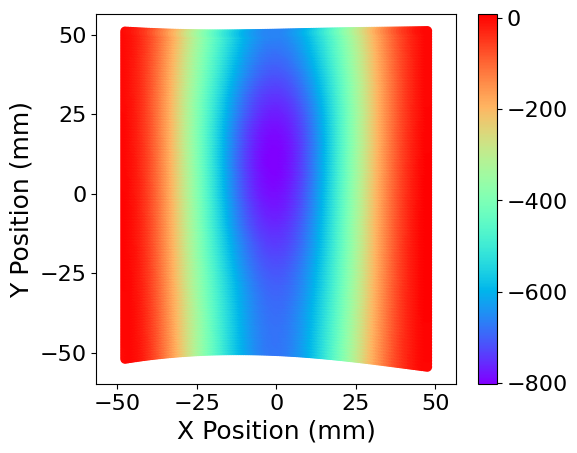

In [81]:
fig, ax = plt.subplots(figsize=(5.8, 4.8))

surf = ax.scatter(X+10*U, Y+10*V, c = N_xx, cmap=cm.rainbow)

cb = fig.colorbar(surf)

cb.ax.tick_params(labelsize=16)

ax.axis('equal')
ax.set_xlabel('X Position (mm)', fontsize=18)
ax.set_ylabel('Y Position (mm)', fontsize=18)
ax.set_xticks(ticks=[-50, -25, 0., 25, 50])
ax.set_yticks(ticks=[-50, -25, 0., 25, 50])
for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)

plt.show()


In [82]:
X = X.reshape(120,120)
Y = Y.reshape(120,120)
W = W.reshape(120,120)
U = U.reshape(120,120)
V = V.reshape(120,120)

N_xx = N_xx.reshape(120,120)
N_yy = N_yy.reshape(120,120)
M_xx = M_xx.reshape(120,120)
M_yy = M_yy.reshape(120,120)

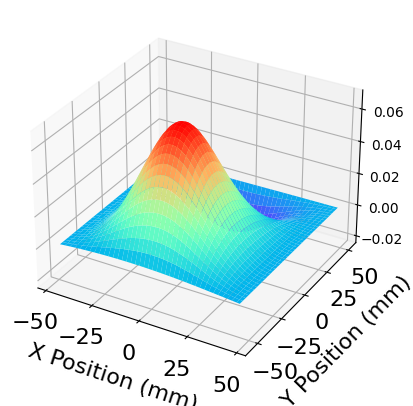

In [83]:
fig = plt.figure(figsize=(8, 4.8))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X+10*U, Y+10*V, W, cmap=cm.rainbow)

cb.ax.tick_params(labelsize=16)

ax.set_xlabel('X Position (mm)', fontsize=16, labelpad=8)
ax.set_ylabel('Y Position (mm)', fontsize=16, labelpad=8)

ax.set_xticks(ticks=[-50, -25, 0., 25, 50])
ax.set_yticks(ticks=[-50, -25, 0., 25, 50])

for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)

plt.show()